In [158]:
import pandas as pd
import seaborn as sns
from nba_api.stats.endpoints import playercareerstats, leaguedashplayershotlocations, leaguehustlestatsteam, leaguehustlestatsplayer, leaguelineupviz, defensehub, hustlestatsboxscore, shotchartlineupdetail, leaguegamelog, boxscoretraditionalv3, playerdashboardbylastngames, playerdashboardbygamesplits, teamestimatedmetrics
from nba_api.stats.static import players, teams


# Goal
Create a player points prop prediction model

# EDA
1. first task should be to find any correlation between team stats (defensive rating, hustle stats, etc) and player points scored

2022-23 games 

In [125]:
szn = '2022-23'

In [ ]:
game_log = leaguegamelog.LeagueGameLog(season=szn).get_data_frames()

In [ ]:
game_log[0].columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [ ]:
gamelog_22_23 = leaguegamelog.LeagueGameLog(season =szn).get_data_frames()[0]

In [52]:
gamelog_22_23.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22022,1610612747,LAL,Los Angeles Lakers,0022200002,2022-10-18,LAL @ GSW,L,240,40,...,39,48,23,12,4,22,18,109,-14,1
1,22022,1610612755,PHI,Philadelphia 76ers,0022200001,2022-10-18,PHI @ BOS,L,240,40,...,27,31,16,8,3,14,25,117,-9,1
2,22022,1610612738,BOS,Boston Celtics,0022200001,2022-10-18,BOS vs. PHI,W,240,46,...,30,36,24,8,3,11,24,126,9,1
3,22022,1610612744,GSW,Golden State Warriors,0022200002,2022-10-18,GSW vs. LAL,W,240,45,...,37,48,31,11,4,18,23,123,14,1
4,22022,1610612742,DAL,Dallas Mavericks,0022200013,2022-10-19,DAL @ PHX,L,240,35,...,35,40,17,6,4,12,22,105,-2,1


In [54]:
game_ids = gamelog_22_23['GAME_ID'].unique()

In [121]:
def combine_team_games(df, keep_method='home'):
    '''Combine a TEAM_ID-GAME_ID unique table into rows by game. Slow.

        Parameters
        ----------
        df : Input DataFrame.
        keep_method : {'home', 'away', 'winner', 'loser', ``None``}, default 'home'
            - 'home' : Keep rows where TEAM_A is the home team.
            - 'away' : Keep rows where TEAM_A is the away team.
            - 'winner' : Keep rows where TEAM_A is the losing team.
            - 'loser' : Keep rows where TEAM_A is the winning team.
            - ``None`` : Keep all rows. Will result in an output DataFrame the same
                length as the input DataFrame.
                
        Returns
        -------
        result : DataFrame
    '''
    # Join every row to all others with the same game ID.
    joined = pd.merge(df, df, suffixes=['_A', '_B'],
                      on=['SEASON_ID', 'GAME_ID', 'GAME_DATE'])
    # Filter out any row that is joined to itself.
    result = joined[joined.TEAM_ID_A != joined.TEAM_ID_B]
    # Take action based on the keep_method flag.
    if keep_method is None:
        # Return all the rows.
        pass
    elif keep_method.lower() == 'home':
        # Keep rows where TEAM_A is the home team.
        result = result[result.MATCHUP_A.str.contains(' vs. ')]
    elif keep_method.lower() == 'away':
        # Keep rows where TEAM_A is the away team.
        result = result[result.MATCHUP_A.str.contains(' @ ')]
    elif keep_method.lower() == 'winner':
        result = result[result.WL_A == 'W']
    elif keep_method.lower() == 'loser':
        result = result[result.WL_A == 'L']
    else:
        raise ValueError(f'Invalid keep_method: {keep_method}')
    return result


In [122]:
    
# Combine the game rows into one. By default, the home team will be TEAM_A.
game_df = combine_team_games(gamelog_22_23)
game_df

,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,FGM_A,...,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PTS_B,PLUS_MINUS_B,VIDEO_AVAILABLE_B
2,22022,1610612744,GSW,Golden State Warriors,0022200002,2022-10-18,GSW vs. LAL,W,240,45,...,39,48,23,12,4,22,18,109,-14,1
6,22022,1610612738,BOS,Boston Celtics,0022200001,2022-10-18,BOS vs. PHI,W,240,46,...,27,31,16,8,3,14,25,117,-9,1
10,22022,1610612756,PHX,Phoenix Suns,0022200013,2022-10-19,PHX vs. DAL,W,240,40,...,35,40,17,6,4,12,22,105,-2,1
13,22022,1610612750,MIN,Minnesota Timberwolves,0022200010,2022-10-19,MIN vs. OKC,W,240,39,...,41,57,22,6,6,14,26,108,-7,1
17,22022,1610612754,IND,Indiana Pacers,0022200004,2022-10-19,IND vs. WAS,L,240,39,...,39,53,21,5,10,17,19,114,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,22022,1610612741,CHI,Chicago Bulls,0022201223,2023-04-09,CHI vs. DET,W,240,40,...,44,59,20,1,3,25,16,81,-22,1
4906,22022,1610612764,WAS,Washington Wizards,0022201222,2023-04-09,WAS vs. HOU,L,240,41,...,38,51,24,8,6,15,15,114,5,1
4910,22022,1610612761,TOR,Toronto Raptors,0022201221,2023-04-09,TOR vs. MIL,W,240,48,...,31,38,28,5,2,14,13,105,-16,1
4914,22022,1610612756,PHX,Phoenix Suns,0022201229,2023-04-09,PHX vs. LAC,L,240,42,...,39,53,22,3,5,10,18,119,5,1


Estimated off rtng and defensive ratings

In [127]:
team_metr = teamestimatedmetrics.TeamEstimatedMetrics(season =szn).get_data_frames()[0]

In [132]:
game_df.head()

,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,FGM_A,...,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PTS_B,PLUS_MINUS_B,VIDEO_AVAILABLE_B
2,22022,1610612744,GSW,Golden State Warriors,0022200002,2022-10-18,GSW vs. LAL,W,240,45,...,39,48,23,12,4,22,18,109,-14,1
6,22022,1610612738,BOS,Boston Celtics,0022200001,2022-10-18,BOS vs. PHI,W,240,46,...,27,31,16,8,3,14,25,117,-9,1
10,22022,1610612756,PHX,Phoenix Suns,0022200013,2022-10-19,PHX vs. DAL,W,240,40,...,35,40,17,6,4,12,22,105,-2,1
13,22022,1610612750,MIN,Minnesota Timberwolves,0022200010,2022-10-19,MIN vs. OKC,W,240,39,...,41,57,22,6,6,14,26,108,-7,1
17,22022,1610612754,IND,Indiana Pacers,0022200004,2022-10-19,IND vs. WAS,L,240,39,...,39,53,21,5,10,17,19,114,7,1


In [129]:
team_metr.head()

,TEAM_NAME,TEAM_ID,GP,W,L,W_PCT,MIN,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,...,MIN_RANK,E_OFF_RATING_RANK,E_DEF_RATING_RANK,E_NET_RATING_RANK,E_AST_RATIO_RANK,E_OREB_PCT_RANK,E_DREB_PCT_RANK,E_REB_PCT_RANK,E_TM_TOV_PCT_RANK,E_PACE_RANK
0,Golden State Warriors,1610612744,82,44,38,0.537,3966.0,113.5,111.4,2.1,...,12,9,12,10,2,14,16,10,29,1
1,San Antonio Spurs,1610612759,82,22,60,0.268,3971.0,107.2,117.7,-10.5,...,8,29,30,30,8,7,24,21,24,2
2,Indiana Pacers,1610612754,82,35,47,0.427,3951.0,111.0,115.4,-4.4,...,25,24,26,26,7,18,30,28,20,3
3,Memphis Grizzlies,1610612763,82,51,31,0.622,3956.0,112.3,108.3,4.0,...,22,14,2,4,15,6,18,6,6,4
4,Oklahoma City Thunder,1610612760,82,40,42,0.488,3971.0,112.3,111.4,0.8,...,8,15,13,14,26,13,29,27,4,5


In [141]:
game_df_1.columns

Index(['key_0', 'SEASON_ID', 'TEAM_ID_A', 'TEAM_ABBREVIATION_A', 'TEAM_NAME_A',
       'GAME_ID', 'GAME_DATE', 'MATCHUP_A', 'WL_A', 'MIN_A', 'FGM_A', 'FGA_A',
       'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A', 'FTM_A', 'FTA_A',
       'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A', 'BLK_A',
       'TOV_A', 'PF_A', 'PTS_A', 'PLUS_MINUS_A', 'VIDEO_AVAILABLE_A',
       'TEAM_ID_B', 'TEAM_ABBREVIATION_B', 'TEAM_NAME_B', 'MATCHUP_B', 'WL_B',
       'MIN_B', 'FGM_B', 'FGA_B', 'FG_PCT_B', 'FG3M_B', 'FG3A_B', 'FG3_PCT_B',
       'FTM_B', 'FTA_B', 'FT_PCT_B', 'OREB_B', 'DREB_B', 'REB_B', 'AST_B',
       'STL_B', 'BLK_B', 'TOV_B', 'PF_B', 'PTS_B', 'PLUS_MINUS_B',
       'VIDEO_AVAILABLE_B', 'TEAM_NAME', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT',
       'MIN', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING', 'E_PACE',
       'E_AST_RATIO', 'E_OREB_PCT', 'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'E_OFF_RATING_RANK', 'E_DEF

In [154]:
home_team_metr

,HOME_TEAM_NAME,HOME_TEAM_ID,HOME_GP,HOME_W,HOME_L,HOME_W_PCT,HOME_MIN,HOME_E_OFF_RATING,HOME_E_DEF_RATING,HOME_E_NET_RATING,...,HOME_MIN_RANK,HOME_E_OFF_RATING_RANK,HOME_E_DEF_RATING_RANK,HOME_E_NET_RATING_RANK,HOME_E_AST_RATIO_RANK,HOME_E_OREB_PCT_RANK,HOME_E_DREB_PCT_RANK,HOME_E_REB_PCT_RANK,HOME_E_TM_TOV_PCT_RANK,HOME_E_PACE_RANK
0,Golden State Warriors,1610612744,82,44,38,0.537,3966.0,113.5,111.4,2.1,...,12,9,12,10,2,14,16,10,29,1
1,San Antonio Spurs,1610612759,82,22,60,0.268,3971.0,107.2,117.7,-10.5,...,8,29,30,30,8,7,24,21,24,2
2,Indiana Pacers,1610612754,82,35,47,0.427,3951.0,111.0,115.4,-4.4,...,25,24,26,26,7,18,30,28,20,3
3,Memphis Grizzlies,1610612763,82,51,31,0.622,3956.0,112.3,108.3,4.0,...,22,14,2,4,15,6,18,6,6,4
4,Oklahoma City Thunder,1610612760,82,40,42,0.488,3971.0,112.3,111.4,0.8,...,8,15,13,14,26,13,29,27,4,5
5,Los Angeles Lakers,1610612747,82,43,39,0.524,3976.0,111.8,111.5,0.3,...,5,19,16,16,18,20,13,12,11,5
6,Minnesota Timberwolves,1610612750,82,42,40,0.512,3966.0,111.3,111.1,0.2,...,12,23,11,20,10,27,26,26,25,7
7,Charlotte Hornets,1610612766,82,27,55,0.329,3966.0,106.7,112.6,-5.9,...,12,30,20,27,20,16,22,23,14,8
8,Atlanta Hawks,1610612737,82,41,41,0.500,3971.0,113.9,113.6,0.3,...,8,7,22,16,22,8,19,15,3,9
9,Utah Jazz,1610612762,82,37,45,0.451,3961.0,112.7,113.8,-1.1,...,18,12,23,22,14,4,23,4,28,9


In [142]:
home_team_metr = team_metr.copy()
home_team_metr.columns = ["HOME_" + c for c in team_metr.columns]
away_team_metr = team_metr.copy()
away_team_metr.columns = ["AWAY_" + c for c in team_metr.columns]

In [148]:
game_df_1 = game_df.merge(home_team_metr, left_on = game_df.TEAM_ID_A, right_on = home_team_metr.HOME_TEAM_ID, how = "left", suffixes= (None, "_HOME")).drop(["key_0"], axis = 1)
game_df_rtng = game_df_1.merge(away_team_metr, left_on = game_df.TEAM_ID_B, right_on = away_team_metr.AWAY_TEAM_ID, how = "left", suffixes = (None, "AWAY")).drop(["key_0"], axis = 1)

In [155]:
# game_df_rtng.loc[(game_df_rtng['TEAM_ABBREVIATION_A'] == 'GSW') | (game_df_rtng['TEAM_ABBREVIATION_B'] == 'GSW'), :]
# print(game_df_rtng.loc[(game_df_rtng['TEAM_ABBREVIATION_A'] == 'GSW') , :].to_string())

## Warriors 2022-23 analysis

In [156]:
home_warriors = game_df_rtng.loc[(game_df_rtng['TEAM_ABBREVIATION_A'] == 'GSW') , :]

In [159]:
print(list(home_warriors.columns))

['SEASON_ID', 'TEAM_ID_A', 'TEAM_ABBREVIATION_A', 'TEAM_NAME_A', 'GAME_ID', 'GAME_DATE', 'MATCHUP_A', 'WL_A', 'MIN_A', 'FGM_A', 'FGA_A', 'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A', 'FTM_A', 'FTA_A', 'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A', 'BLK_A', 'TOV_A', 'PF_A', 'PTS_A', 'PLUS_MINUS_A', 'VIDEO_AVAILABLE_A', 'TEAM_ID_B', 'TEAM_ABBREVIATION_B', 'TEAM_NAME_B', 'MATCHUP_B', 'WL_B', 'MIN_B', 'FGM_B', 'FGA_B', 'FG_PCT_B', 'FG3M_B', 'FG3A_B', 'FG3_PCT_B', 'FTM_B', 'FTA_B', 'FT_PCT_B', 'OREB_B', 'DREB_B', 'REB_B', 'AST_B', 'STL_B', 'BLK_B', 'TOV_B', 'PF_B', 'PTS_B', 'PLUS_MINUS_B', 'VIDEO_AVAILABLE_B', 'HOME_TEAM_NAME', 'HOME_TEAM_ID', 'HOME_GP', 'HOME_W', 'HOME_L', 'HOME_W_PCT', 'HOME_MIN', 'HOME_E_OFF_RATING', 'HOME_E_DEF_RATING', 'HOME_E_NET_RATING', 'HOME_E_PACE', 'HOME_E_AST_RATIO', 'HOME_E_OREB_PCT', 'HOME_E_DREB_PCT', 'HOME_E_REB_PCT', 'HOME_E_TM_TOV_PCT', 'HOME_GP_RANK', 'HOME_W_RANK', 'HOME_L_RANK', 'HOME_W_PCT_RANK', 'HOME_MIN_RANK', 'HOME_E_OFF_RATING_RANK', 'H

/opt/homebrew/anaconda3/envs/nba/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/nba/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='AWAY_E_PACE', ylabel='PTS_B'>

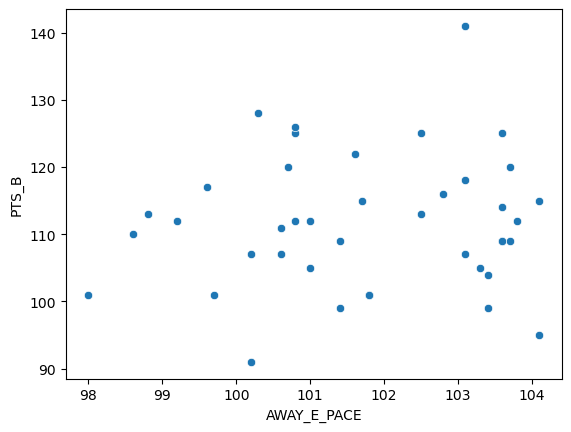

In [161]:
sns.scatterplot(home_warriors, x = "AWAY_E_PACE", y = "PTS_B")

/opt/homebrew/anaconda3/envs/nba/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/nba/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='AWAY_E_DEF_RATING', ylabel='PTS_A'>

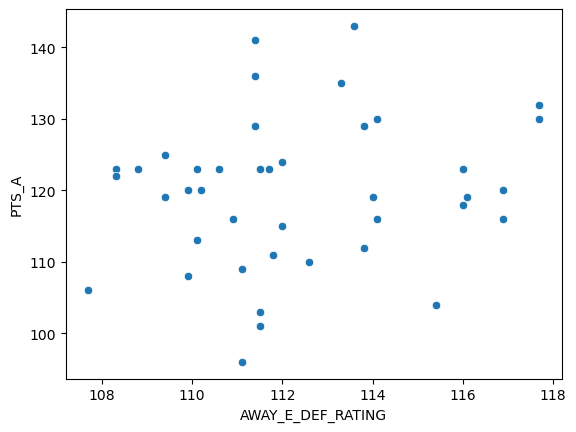

In [160]:
sns.scatterplot(home_warriors, x = "AWAY_E_DEF_RATING", y = "PTS_A")

In [ ]:
home_warriors.

In [123]:
game_df.columns

Index(['SEASON_ID', 'TEAM_ID_A', 'TEAM_ABBREVIATION_A', 'TEAM_NAME_A',
       'GAME_ID', 'GAME_DATE', 'MATCHUP_A', 'WL_A', 'MIN_A', 'FGM_A', 'FGA_A',
       'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A', 'FTM_A', 'FTA_A',
       'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A', 'BLK_A',
       'TOV_A', 'PF_A', 'PTS_A', 'PLUS_MINUS_A', 'VIDEO_AVAILABLE_A',
       'TEAM_ID_B', 'TEAM_ABBREVIATION_B', 'TEAM_NAME_B', 'MATCHUP_B', 'WL_B',
       'MIN_B', 'FGM_B', 'FGA_B', 'FG_PCT_B', 'FG3M_B', 'FG3A_B', 'FG3_PCT_B',
       'FTM_B', 'FTA_B', 'FT_PCT_B', 'OREB_B', 'DREB_B', 'REB_B', 'AST_B',
       'STL_B', 'BLK_B', 'TOV_B', 'PF_B', 'PTS_B', 'PLUS_MINUS_B',
       'VIDEO_AVAILABLE_B'],
      dtype='object')

In [55]:
len(game_ids)

1230

## Players

In [65]:
player_df = pd.DataFrame(players.get_players())

In [70]:
player_df.loc[player_df['full_name'] == "Joel Embiid", :]

,id,full_name,first_name,last_name,is_active
1247,203954,Joel Embiid,Joel,Embiid,True


In [ ]:
nba_players = players.get_players()
print("Number of players fetched: {}".format(len(nba_players)))
nba_players[:5]

In [76]:
df = playerdashboardbygamesplits.PlayerDashboardByGameSplits(player_id = '203954', season = '2022-23', last_n_games = 82).get_data_frames()[0]

In [77]:
df

,GROUP_SET,GROUP_VALUE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,Overall,2022-23,66,43,23,0.652,2284.106667,728,1328,0.548,...,1,1,1,1,1,1,1,1,1,1


## [Traditional box score](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/boxscoretraditionalv3.md)

In [78]:
box_scores = []
for gid in game_ids:
    box_scores.append(boxscoretraditionalv3.BoxScoreTraditionalV3(game_id = gid))

In [80]:
box_score_dfs = [g.get_data_frames()[0] for g in box_scores]

In [82]:
player_box = pd.concat(box_score_dfs)

In [83]:
player_box.head()

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
0,0022200002,1610612747,Los Angeles,Lakers,LAL,lakers,1629022,Lonnie,Walker IV,L. Walker IV,...,1,2,3,5,1,1,2,0,5,-13.0
1,0022200002,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,5,10,15,8,0,0,5,2,31,-10.0
2,0022200002,1610612747,Los Angeles,Lakers,LAL,lakers,203076,Anthony,Davis,A. Davis,...,0,6,6,0,4,1,3,2,27,-21.0
3,0022200002,1610612747,Los Angeles,Lakers,LAL,lakers,201566,Russell,Westbrook,R. Westbrook,...,1,10,11,3,1,0,4,1,19,-6.0
4,0022200002,1610612747,Los Angeles,Lakers,LAL,lakers,201976,Patrick,Beverley,P. Beverley,...,1,1,2,2,4,2,1,5,3,-5.0


In [84]:
# player_box.to_csv("player_boxscores_2023_2024.csv")

In [89]:
player_box.columns

Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade',
       'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade',
       'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive',
       'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks',
       'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints'],
      dtype='object')

In [105]:
player_box['minutes'].str.extract(r'^([0-9]+):').dropna().astype(int).describe()

,0
count,25894.000000
mean,22.482506
std,10.818558
min,0.000000
25%,15.000000
50%,23.000000
75%,31.000000
max,55.000000


In [107]:
player_box['minute'] = player_box['minutes'].str.extract(r'^([0-9]+):').astype(float)

In [108]:
len(player_box)

31542

In [ ]:
sum(player_box['minute'] > 23)

12900

In [110]:
rotation_box = player_box.loc[player_box['minute'] > 23, :]

In [111]:
rotation_box['reboundsTotal'].describe()

count    12900.000000
mean         5.700388
std          3.595086
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         29.000000
Name: reboundsTotal, dtype: float64

In [115]:
embiid = player_box.loc[player_box['personId'] == 203954, :]

In [119]:
embiid

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,minute
2,0022200001,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,14,15,5,0,1,6,4,26,-13.0,37.0
16,0022200015,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,11,12,3,0,1,4,2,15,-10.0,36.0
17,0022200028,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,10,13,3,1,2,2,2,40,6.0,35.0
16,0022200044,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,4,5,2,1,3,3,5,26,8.0,28.0
2,0022200059,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,5,5,3,0,0,2,2,31,-5.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0022201139,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,8,9,3,1,1,4,4,25,10.0,33.0
15,0022201150,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,11,12,1,0,1,5,3,25,0.0,33.0
2,0022201174,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,8,9,5,0,0,1,4,28,-10.0,31.0
14,0022201181,1610612755,Philadelphia,76ers,PHI,sixers,203954,Joel,Embiid,J. Embiid,...,11,13,6,0,2,3,3,52,17.0,38.0


In [120]:
embiid['points'].describe()

count    69.000000
mean     31.637681
std      10.999961
min       0.000000
25%      27.000000
50%      32.000000
75%      38.000000
max      59.000000
Name: points, dtype: float64

In [118]:
(embiid['reboundsTotal']/embiid['minute']).describe()

count    66.000000
mean      0.299744
std       0.088472
min       0.135135
25%       0.236815
50%       0.292220
75%       0.363636
max       0.500000
dtype: float64

In [114]:
player_box['minute']

0     29.0
1     35.0
2     35.0
3     30.0
4     24.0
      ... 
17    35.0
18    23.0
19     NaN
20     NaN
21     NaN
Name: minute, Length: 31542, dtype: float64

In [113]:
player_box.loc[player_box['personId'] == 203954, :]['reboundsTotal'].astype(int)/player_box['minute']

0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
      ..
29   NaN
29   NaN
29   NaN
29   NaN
29   NaN
Length: 106572, dtype: float64

In [91]:
player_box.loc[player_box['personId'] == 203954, :]['reboundsTotal'].describe()

count    69.000000
mean      9.710145
std       3.734188
min       0.000000
25%       7.000000
50%      10.000000
75%      12.000000
max      19.000000
Name: reboundsTotal, dtype: float64

## [Player shot location](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashplayershotlocations.md)

## [](Team defense)

In [ ]:
hustlestatsboxscore.HustleStatsBoxScore()

In [36]:
res = leaguedashplayershotlocations.LeagueDashPlayerShotLocations(last_n_games=1)

In [38]:
df = res.get_data_frames()[0]

In [40]:
df.columns

MultiIndex([(                     '',         'PLAYER_ID'),
            (                     '',       'PLAYER_NAME'),
            (                     '',           'TEAM_ID'),
            (                     '', 'TEAM_ABBREVIATION'),
            (                     '',               'AGE'),
            (                     '',          'NICKNAME'),
            (      'Restricted Area',               'FGM'),
            (      'Restricted Area',               'FGA'),
            (      'Restricted Area',            'FG_PCT'),
            ('In The Paint (Non-RA)',               'FGM'),
            ('In The Paint (Non-RA)',               'FGA'),
            ('In The Paint (Non-RA)',            'FG_PCT'),
            (            'Mid-Range',               'FGM'),
            (            'Mid-Range',               'FGA'),
            (            'Mid-Range',            'FG_PCT'),
            (        'Left Corner 3',               'FGM'),
            (        'Left Corner 3',   

In [12]:
from nba_api.stats.static import teams, players

In [10]:
players.get_players()

[{'id': 76001,
  'full_name': 'Alaa Abdelnaby',
  'first_name': 'Alaa',
  'last_name': 'Abdelnaby',
  'is_active': False},
 {'id': 76002,
  'full_name': 'Zaid Abdul-Aziz',
  'first_name': 'Zaid',
  'last_name': 'Abdul-Aziz',
  'is_active': False},
 {'id': 76003,
  'full_name': 'Kareem Abdul-Jabbar',
  'first_name': 'Kareem',
  'last_name': 'Abdul-Jabbar',
  'is_active': False},
 {'id': 51,
  'full_name': 'Mahmoud Abdul-Rauf',
  'first_name': 'Mahmoud',
  'last_name': 'Abdul-Rauf',
  'is_active': False},
 {'id': 1505,
  'full_name': 'Tariq Abdul-Wahad',
  'first_name': 'Tariq',
  'last_name': 'Abdul-Wahad',
  'is_active': False},
 {'id': 949,
  'full_name': 'Shareef Abdur-Rahim',
  'first_name': 'Shareef',
  'last_name': 'Abdur-Rahim',
  'is_active': False},
 {'id': 76005,
  'full_name': 'Tom Abernethy',
  'first_name': 'Tom',
  'last_name': 'Abernethy',
  'is_active': False},
 {'id': 76006,
  'full_name': 'Forest Able',
  'first_name': 'Forest',
  'last_name': 'Able',
  'is_active': Fa

In [8]:
teams.get_teams()

[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Georgia',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970},
 {'id': 1610612740,
  'full_name': 'New Orleans Pelicans',
  'abbreviation': 'NOP',
  'nickname': 'Pelicans',
  'city': 'New Orleans',
  'state': 'Louisiana',
  'year_founded': 2002},
 {'id': 1610612741,
  'full_name': 'Chicago Bulls',
  'abbreviation': 'CHI',
  'nickname': 'Bulls',
  'city': 'Chicago',
  'state': 'Illinois',
  'year_founded': 1966},
 {'id': 1610612742,
  'full_name': 'Dallas Mavericks',
  'abbreviation': 'DAL',
  'nickname': 'Mavericks',
  'city': 'Dallas',

In [2]:
career = playercareerstats.PlayerCareerStats(player_id='203999') 


In [4]:
career.get_available_data()

dict_keys(['SeasonTotalsRegularSeason', 'CareerTotalsRegularSeason', 'SeasonTotalsPostSeason', 'CareerTotalsPostSeason', 'SeasonTotalsAllStarSeason', 'CareerTotalsAllStarSeason', 'SeasonTotalsCollegeSeason', 'CareerTotalsCollegeSeason', 'SeasonTotalsShowcaseSeason', 'CareerTotalsShowcaseSeason', 'SeasonRankingsRegularSeason', 'SeasonRankingsPostSeason'])

In [5]:
career.get_data_frames()

[   PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
 0     203999   2015-16        00  1610612743               DEN        21.0   
 1     203999   2016-17        00  1610612743               DEN        22.0   
 2     203999   2017-18        00  1610612743               DEN        23.0   
 3     203999   2018-19        00  1610612743               DEN        24.0   
 4     203999   2019-20        00  1610612743               DEN        25.0   
 5     203999   2020-21        00  1610612743               DEN        26.0   
 6     203999   2021-22        00  1610612743               DEN        27.0   
 7     203999   2022-23        00  1610612743               DEN        28.0   
 8     203999   2023-24        00  1610612743               DEN        28.0   
 
    GP  GS     MIN  FGM  ...  FT_PCT  OREB  DREB   REB  AST  STL  BLK  TOV  \
 0  80  55  1733.0  307  ...   0.811   181   379   560  189   79   50  104   
 1  73  59  2038.0  494  ...   0.825   212   506   7